# Time Series Forecasting

### Here, we will try to forecast the number of orders using Time Series Forecasting. We will cummulate the number of orders received on a daily basis.

### We will then predict the number of orders for the future. We will find the prefect Time Series forecasting models to get the prediction.

# Imports

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Loading the CSV files

In [8]:
df1 = pd.read_csv("../food_delivery_dataset/train.csv")

df1['Order_Date'] = pd.to_datetime(df1['Order_Date'])

df1 = df1.groupby('Order_Date').size().reset_index(name='count')

/var/folders/2t/gftqwtk579jcc7_0379k_f900000gn/T/ipykernel_64133/1130109973.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['Order_Date'] = pd.to_datetime(df1['Order_Date'])


In [9]:
df1.columns = ['timestamp','Count']
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [10]:
df1 = df1.set_index('timestamp')

## Ploting the graph with the Daily Order Count

In [11]:
y = df1['Count']
y['2022':]

timestamp
2022-02-11     970
2022-02-12     864
2022-02-13     957
2022-02-14     851
2022-02-15     945
2022-02-16     861
2022-02-17     939
2022-02-18     855
2022-03-01    1140
2022-03-02    1012
2022-03-03    1150
2022-03-04     981
2022-03-05    1154
2022-03-06     986
2022-03-07    1153
2022-03-08     964
2022-03-09    1159
2022-03-10     996
2022-03-11    1149
2022-03-12     964
2022-03-13    1169
2022-03-14     974
2022-03-15    1192
2022-03-16     995
2022-03-17    1134
2022-03-18     968
2022-03-19    1150
2022-03-20     994
2022-03-21    1149
2022-03-23     964
2022-03-24    1162
2022-03-25     975
2022-03-26    1166
2022-03-27     965
2022-03-28    1139
2022-03-29     977
2022-03-30    1141
2022-03-31     967
2022-04-01    1133
2022-04-02     992
2022-04-03    1178
2022-04-04     941
2022-04-05    1157
2022-04-06     961
Name: Count, dtype: int64

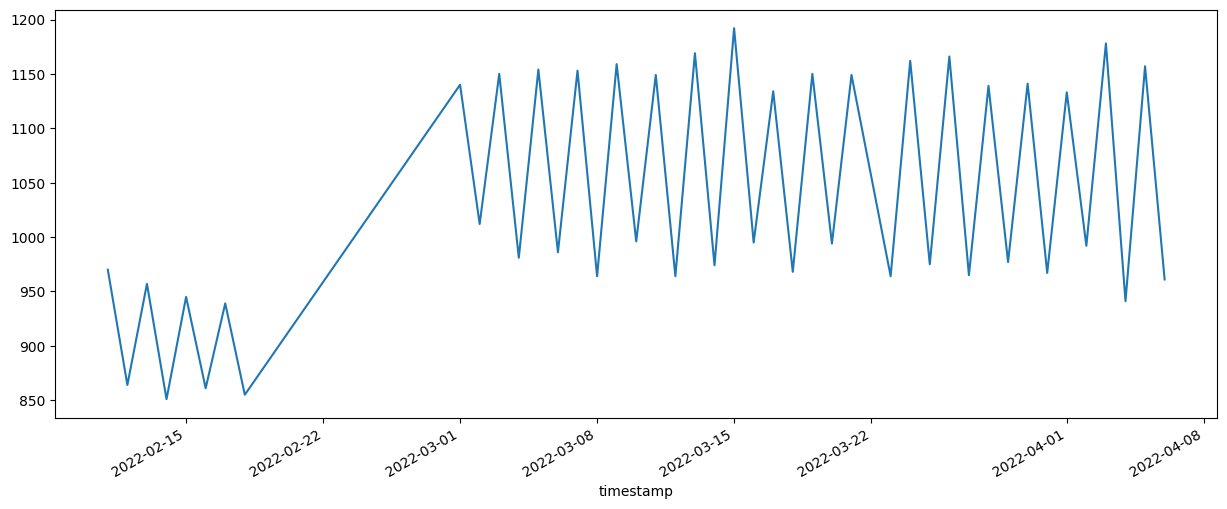

In [12]:
y.plot(figsize=(15,6))
plt.show()

## We compute the Trend, Seaonality and Residual (Noise) of the current data.

- The trend is the long-term movement or direction in the time series data
- Seasonality refers to the repeating and predictable patterns or cycles in the data that occur at regular intervals, typically within a year, month, or week.
- The residuals (or noise) represent the random or unexplained variation in the data after removing the trend and seasonality components

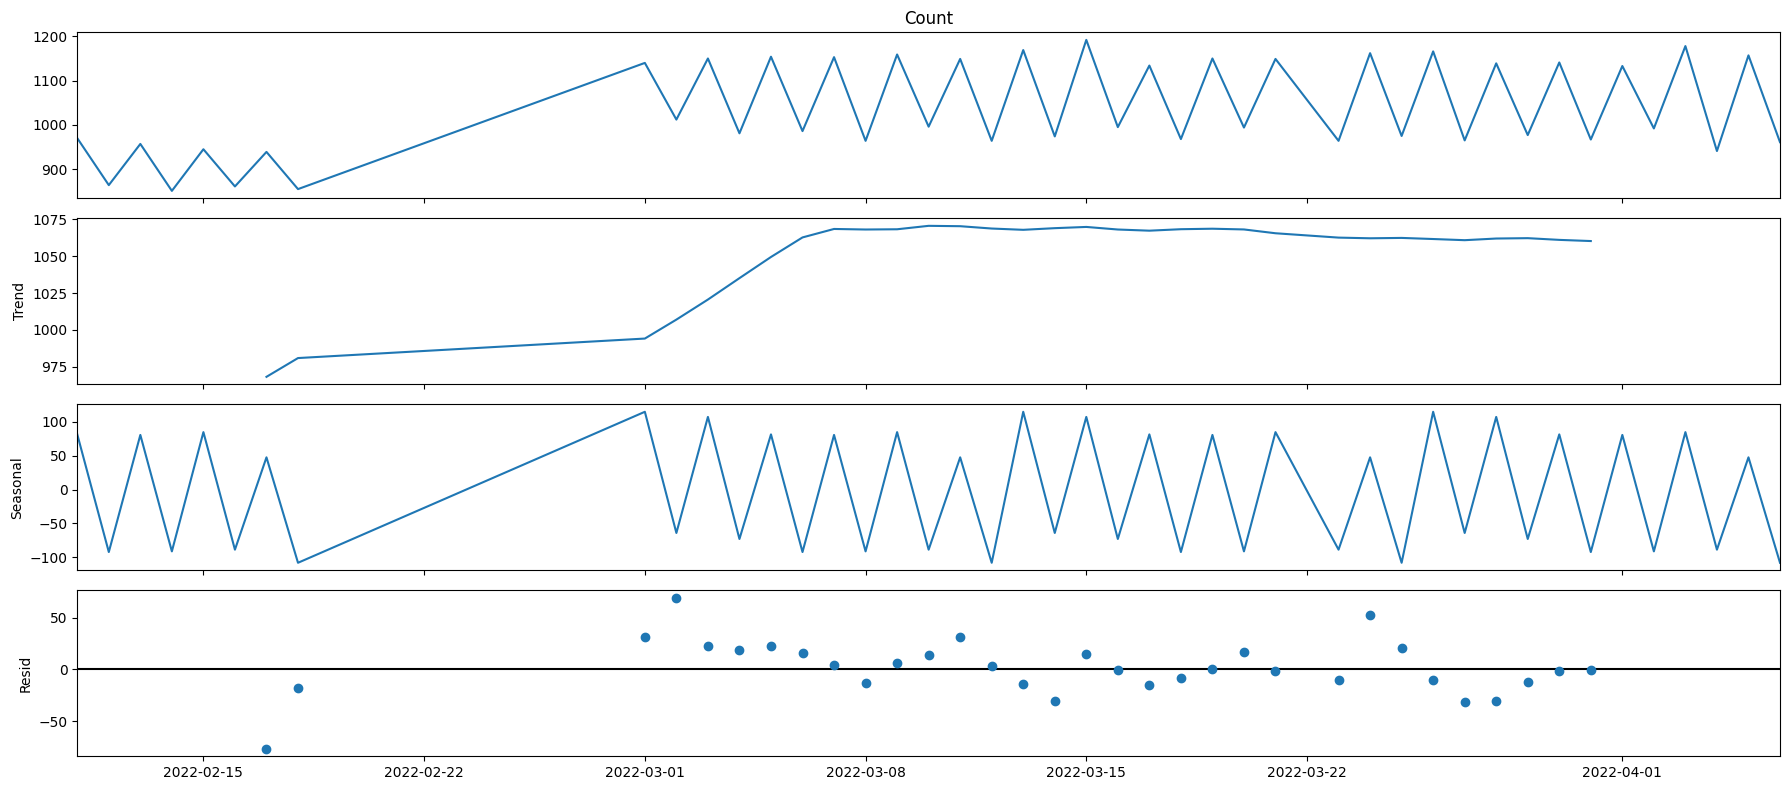

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=12)
fig = decomposition.plot()
plt.show()

## As we can see a pattern in the Seasonality of the data. So, we use SARIMA to predict the outputs.

In [15]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(e)
            break


## We try to plot the graph using the values obtained using SARIMA Model

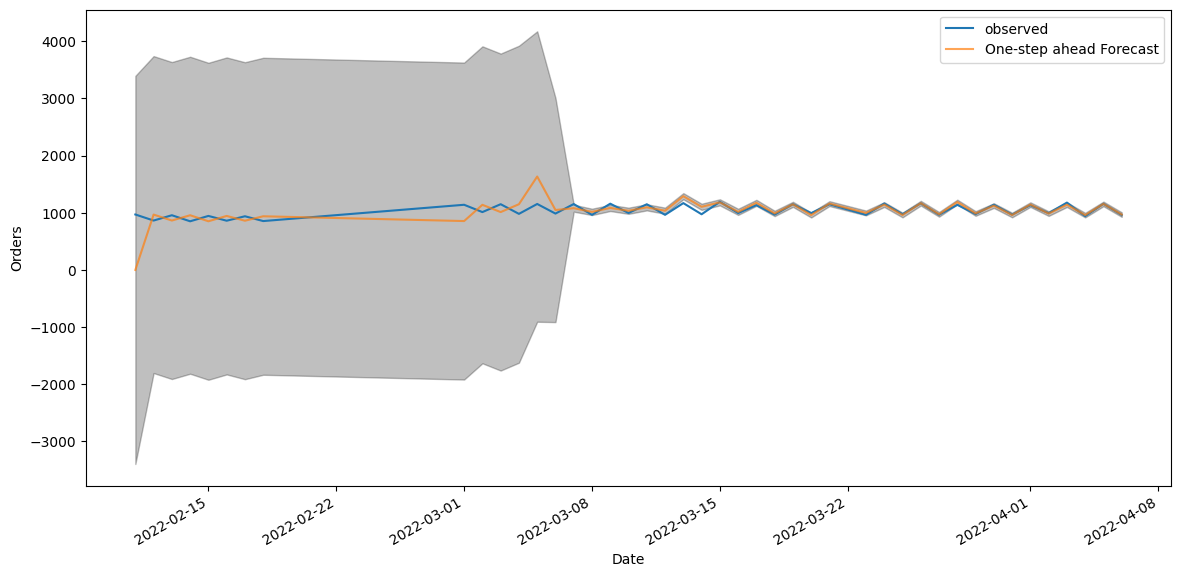

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2022-02-11'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2022':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Orders')
plt.legend()
plt.show()

## We compute the Mean Square Error For the SARIMA model.

In [140]:
y_forecasted = pred.predicted_mean
y_truth = y['2022-02-11':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 32824.41


## We compute the Root Mean Squared Error for the SARIMA Model

In [141]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 181.18


## We now want to plot the predicts for the given data.

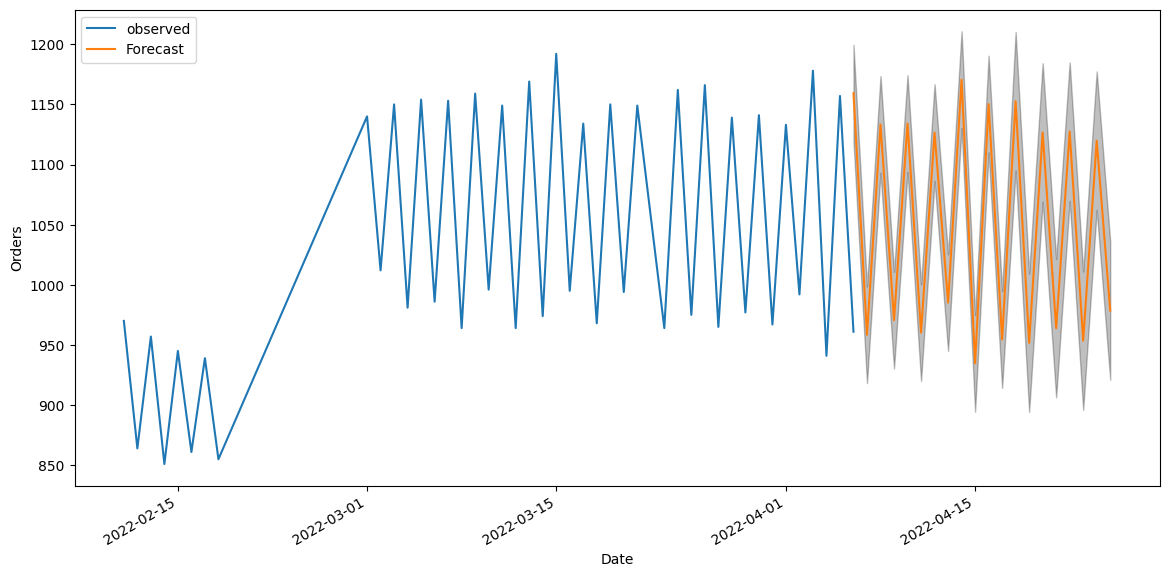

In [199]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
forecast_index = pd.date_range(start='2022-04-06', periods=len(pred_uc.predicted_mean), freq='D')
pred_ci.index = pd.date_range(start='2022-04-06', periods=len(pred_ci.index), freq='D')
ax = y.plot(label='observed', figsize=(14, 7))
forecast = pred_uc.predicted_mean
forecast.index = forecast_index
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Orders')
plt.legend()
plt.show()

### Here, we see the orange line is the predicted value, based on the SARIMA Time Series Forecasting. The gray part is the expected noise in the data. 

### We can use the predicted values for various advancements and optimissatins.

### One problem with the given data is the Dataset size. We have around about 2 months of data. In order to unlock the true potential of Time Series Forecasting, we need atleast 2 years of data. 

### We will perform the above predictions but on a bigger dataset in-order to test the performance of Time Series Forecasting.